In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [4]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

In [5]:
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

In [6]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [20]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [21]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

In [22]:
IMAGE_SIZE = (12, 8)

In [23]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
      # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
            # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
            # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
                
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

          # Run inference
            output_dict = sess.run(tensor_dict,feed_dict={image_tensor: image})

          # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [24]:
%matplotlib inline 

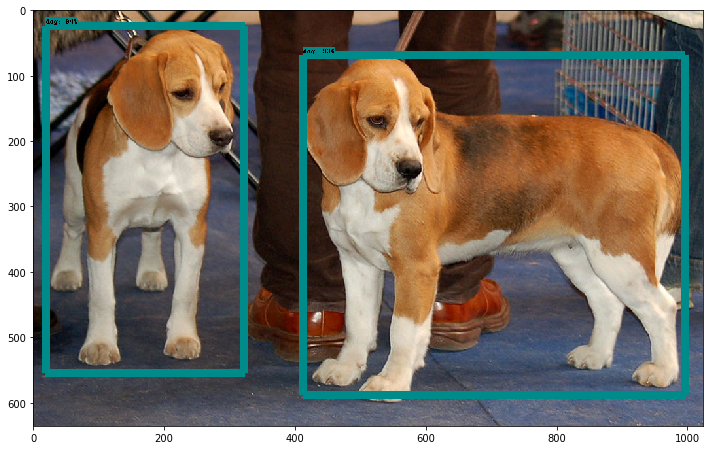

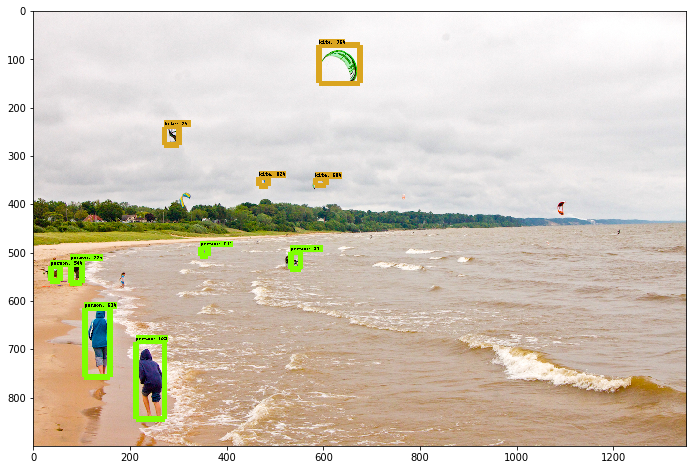

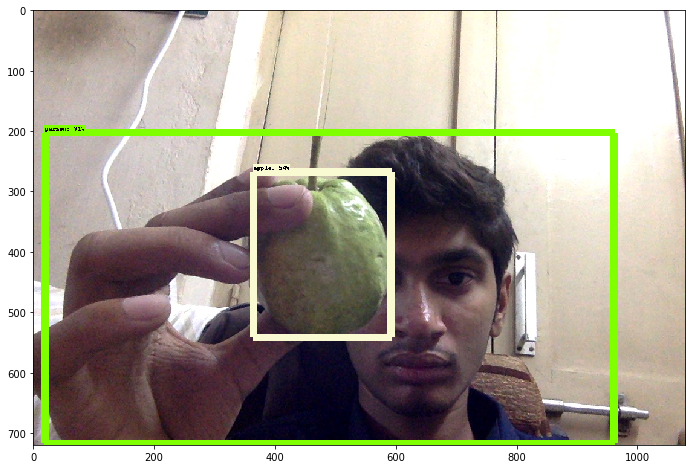

In [29]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
#     print(output_dict['detection_boxes'])
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(image_np,output_dict['detection_boxes'],output_dict['detection_classes'],output_dict['detection_scores'],category_index,instance_masks=output_dict.get('detection_masks'),use_normalized_coordinates=True,line_thickness=12)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [ ]:
import cv2

IM_WIDTH = 640    # Use smaller resolution for
IM_HEIGHT = 480  # slightly faster framerate

frame_rate_calc = 1
freq = cv2.getTickFrequency()
font = cv2.FONT_HERSHEY_SIMPLEX

camera = cv2.VideoCapture(0)
ret = camera.set(3,IM_WIDTH)
ret = camera.set(4,IM_HEIGHT)

while True:

        t1 = cv2.getTickCount()

        # Acquire frame and expand frame dimensions to have shape: [1, None, None, 3]
        # i.e. a single-column array, where each item in the column has the pixel RGB value
        ret, frame = camera.read()
        frame_expanded = np.expand_dims(frame, axis=0)
        
        output_dict = run_inference_for_single_image(frame_expanded, detection_graph)

        # Perform the actual detection by running the model with the image as input
#         (boxes, scores, classes, num) = sess.run(
#             [detection_boxes, detection_scores, detection_classes, num_detections],
#             feed_dict={image_tensor: frame_expanded})

        # Draw the results of the detection (aka 'visulaize the results')
        vis_util.visualize_boxes_and_labels_on_image_array(
            frame,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8,
            min_score_thresh=0.70)

        cv2.putText(frame,"FPS: {0:.2f}".format(frame_rate_calc),(30,50),font,1,(255,255,0),2,cv2.LINE_AA)
        
        # All the results have been drawn on the frame, so it's time to display it.
        cv2.imshow('Object detector', frame)

        t2 = cv2.getTickCount()
        time1 = (t2-t1)/freq
        frame_rate_calc = 1/time1

        # Press 'q' to quit
        if cv2.waitKey(1) == ord('q'):
            break

camera.release()